<a href="https://colab.research.google.com/github/Raunak22-Dev/Signature_Verification_System_USING_SNN/blob/main/Signature_Verification_System_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import matplotlib.pyplot as plt
import numpy as np
import random

from PIL import Image
import torch.nn as nn
import torch.nn.functional as F


In [2]:
#Download the Dataset from Kaggle
"https://www.kaggle.com/datasets/shreelakshmigp/cedardataset?resource=download"

'https://www.kaggle.com/datasets/shreelakshmigp/cedardataset?resource=download'

In [3]:
#Creating Device Agnostic code
device ="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(42)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!unzip "/content/drive/MyDrive/Ai_ML_Project/CEDAR.zip" -d /content/CEDAR

Archive:  /content/drive/MyDrive/Ai_ML_Project/CEDAR.zip
  inflating: /content/CEDAR/signatures/full_forg/Thumbs.db  
  inflating: /content/CEDAR/signatures/full_forg/forgeries_10_1.png  
  inflating: /content/CEDAR/signatures/full_forg/forgeries_10_10.png  
  inflating: /content/CEDAR/signatures/full_forg/forgeries_10_11.png  
  inflating: /content/CEDAR/signatures/full_forg/forgeries_10_12.png  
  inflating: /content/CEDAR/signatures/full_forg/forgeries_10_13.png  
  inflating: /content/CEDAR/signatures/full_forg/forgeries_10_14.png  
  inflating: /content/CEDAR/signatures/full_forg/forgeries_10_15.png  
  inflating: /content/CEDAR/signatures/full_forg/forgeries_10_16.png  
  inflating: /content/CEDAR/signatures/full_forg/forgeries_10_17.png  
  inflating: /content/CEDAR/signatures/full_forg/forgeries_10_18.png  
  inflating: /content/CEDAR/signatures/full_forg/forgeries_10_19.png  
  inflating: /content/CEDAR/signatures/full_forg/forgeries_10_2.png  
  inflating: /content/CEDAR/sign

In [7]:
!find dataset_clean -name "Thumbs.db" -delete

find: ‘dataset_clean’: No such file or directory


In [8]:
import os
import random
import shutil
from glob import glob

# Paths to original CEDAR data
cedar_genuine = "/content/CEDAR/signatures/full_org"
cedar_forged  = "/content/CEDAR/signatures/full_forg"

# Target clean dataset
target_dir = "/content/dataset_clean"
os.makedirs(f"{target_dir}/train/genuine", exist_ok=True)
os.makedirs(f"{target_dir}/train/forg", exist_ok=True)
os.makedirs(f"{target_dir}/test/genuine", exist_ok=True)
os.makedirs(f"{target_dir}/test/forg", exist_ok=True)

# Valid extensions
valid_ext = (".png", ".jpg", ".jpeg")

# Collect file lists
genuine_imgs = [f for f in glob(f"{cedar_genuine}/*") if f.lower().endswith(valid_ext)]
forged_imgs  = [f for f in glob(f"{cedar_forged}/*") if f.lower().endswith(valid_ext)]

random.shuffle(genuine_imgs)
random.shuffle(forged_imgs)

# Split into train/test
split_ratio = 0.8
split_genuine = int(split_ratio * len(genuine_imgs))
split_forged  = int(split_ratio * len(forged_imgs))

# Copy genuine
for i, img_path in enumerate(genuine_imgs):
  filename = os.path.basename(img_path)
  if i < split_genuine:
    shutil.copy(img_path, f"{target_dir}/train/genuine/{filename}")
  else:
    shutil.copy(img_path, f"{target_dir}/test/genuine/{filename}")

# Copy forged
for i, img_path in enumerate(forged_imgs):
  filename = os.path.basename(img_path)
  if i < split_forged:
    shutil.copy(img_path, f"{target_dir}/train/forg/{filename}")
  else:
    shutil.copy(img_path, f"{target_dir}/test/forg/{filename}")

In [9]:
#orb_match.py

import cv2

def preprocess(img):
  """Preprocess image for better ORB detection"""
  # Resize for consistency
  img = cv2.resize(img, (300, 150))
  # Gaussian blur to remove noise
  img = cv2.GaussianBlur(img, (5, 5), 0)
  # Thresholding (binary)
  _, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  # Invert -> signature white on black
  img = cv2.bitwise_not(img)
  return img

def compare_signatures(img1_path,img2_path,match_ratio=0.3):
  #Read images
  img1=cv2.imread(img1_path,cv2.IMREAD_GRAYSCALE)
  img2=cv2.imread(img2_path,cv2.IMREAD_GRAYSCALE)

  if img1 is None or img2 is None:
    return "⚠️ Error: Image not found"

  img1=preprocess(img1)
  img2=preprocess(img2)

  #ORB detector
  orb=cv2.ORB_create(500)
  kp1,des1=orb.detectAndCompute(img1,None)
  kp2,des2=orb.detectAndCompute(img2,None)

  if des1 is None or des2 is None:
    return "⚠️ No keypoints detected, try another image"

  #Matcher
  bf=cv2.BFMatcher(cv2.NORM_HAMMING,crossCheck=True)
  matches=bf.match(des1,des2)
  matches= sorted(matches,key=lambda x : x.distance)

  good_matches=[m for m in matches if m.distance <60] #quality filter

  print(f"keypionts:{len(kp1)} V|S {len(kp2)} |  Good matches: {len(good_matches)}")


  # Calculate similarity ratio
  ratio=len(good_matches)/min(len(kp1),len(kp2)) if min(len(kp1), len(kp2)) > 0 else 0

  if ratio > match_ratio:
    return f"✅ Genuine Signature (Match ratio: {ratio:.2f})"
  else:
    return f"❌ Forged Signature (Match ratio: {ratio:.2f})"

def visualize_orb_matches(img1_path, img2_path, max_matches=20):
  img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
  img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

  orb = cv2.ORB_create()
  kp1, des1 = orb.detectAndCompute(img1, None)
  kp2, des2 = orb.detectAndCompute(img2, None)

  bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
  matches = sorted(bf.match(des1, des2), key=lambda x: x.distance)

  match_img = cv2.drawMatches(img1, kp1, img2, kp2, matches[:max_matches], None, flags=2)

  plt.figure(figsize=(10,6))
  plt.imshow(match_img, cmap="gray")
  plt.title("ORB Keypoint Matches")
  plt.axis("off")
  plt.show()


In [10]:

def visualize_orb_matches(img1_path, img2_path, max_matches=20):
  """
  Visualize ORB keypoint matches between two images.
  """
  img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
  img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

  # Check if images loaded
  if img1 is None:
    raise FileNotFoundError(f"Could not read image: {img1_path}")
  if img2 is None:
    raise FileNotFoundError(f"Could not read image: {img2_path}")

  orb = cv2.ORB_create()
  kp1, des1 = orb.detectAndCompute(img1, None)
  kp2, des2 = orb.detectAndCompute(img2, None)

  if des1 is None or des2 is None:
    print("No descriptors found in one or both images.")
    return

  bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
  matches = sorted(bf.match(des1, des2), key=lambda x: x.distance)

  if len(matches) == 0:
    print("No matches found between images.")
    return

  match_img = cv2.drawMatches(img1, kp1, img2, kp2, matches[:max_matches], None, flags=2)

  plt.figure(figsize=(10,6))
  plt.imshow(match_img, cmap="gray")
  plt.title("ORB Keypoint Matches")
  plt.axis("off")
  plt.show()


keypionts:282 V|S 282 |  Good matches: 282
Genuine vs Genuine: ✅ Genuine Signature (Match ratio: 1.00)
keypionts:190 V|S 268 |  Good matches: 40
Genuine vs Forged: ❌ Forged Signature (Match ratio: 0.21)


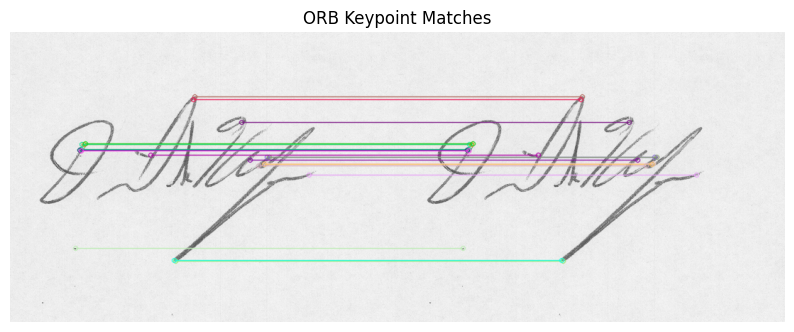

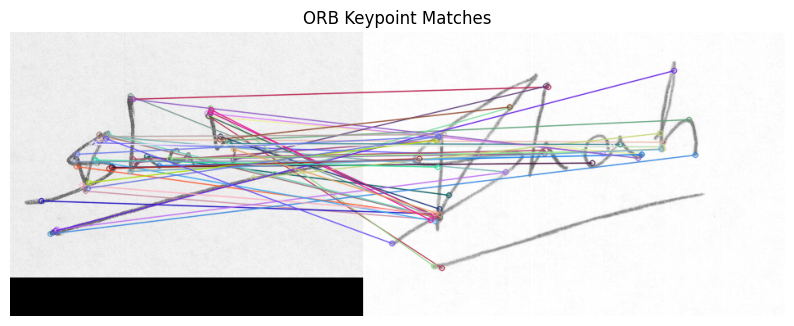

In [11]:
# Example Usage
if __name__ == "__main__":
  result1 = compare_signatures(
      "/content/dataset_clean/test/genuine/original_10_12.png", #gen
      "/content/dataset_clean/test/genuine/original_10_12.png",#gen
  )
  print("Genuine vs Genuine:", result1)

  result2 = compare_signatures(
      "/content/dataset_clean/test/genuine/original_23_19.png",#gen
      "/content/dataset_clean/test/forg/forgeries_23_19.png"#forg
  )
  print("Genuine vs Forged:", result2)
visualize_orb_matches("/content/dataset_clean/test/genuine/original_10_12.png","/content/dataset_clean/test/genuine/original_10_12.png", max_matches=20)
visualize_orb_matches("/content/dataset_clean/test/genuine/original_23_19.png","/content/dataset_clean/test/forg/forgeries_23_19.png", max_matches=50)

In [39]:
# OpenCV preprocessing (OpenCV crop → square pad → RGB PIL)
def preprocess_signature(path, size=224):
  img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  if img is None:
    raise FileNotFoundError(f"Image not found: {path}")

  # Invert if dark background
  if np.mean(img) < 127:
    img = cv2.bitwise_not(img)

  # Otsu binarize + slight denoise
  _, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  img = cv2.medianBlur(img, 3)

  # Crop to non-zero content
  nz = cv2.findNonZero(img)
  if nz is not None:
    x, y, w, h = cv2.boundingRect(nz)
    img = img[y:y+h, x:x+w]

  # Resize keeping aspect, then pad to square (white background)
  h, w = img.shape[:2]
  if h == 0 or w == 0:
    # fallback: load as PIL and resize
    pil = Image.open(path).convert("L").resize((size, size))
    return pil.convert("RGB")
  scale = size / max(h, w)

  new_w = int(w * scale)
  new_h = int(h * scale)

  img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

  pad_x = (size - new_w) // 2
  pad_y = (size - new_h) // 2

  img = cv2.copyMakeBorder(img,
                            pad_y, size - new_h - pad_y,
                            pad_x, size - new_w - pad_x,
                            cv2.BORDER_CONSTANT, value=255)
  # to RGB PIL
  img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
  return Image.fromarray(img)

In [40]:
# PairDataset (uses OpenCV preprocessing)
class PairDataset(Dataset):
  def __init__(self, root_dir, n_pairs_per_epoch=2000, size=224, augment=True):
    """
    root_dir e.g. dataset_clean/train
      - genuine/*.png|jpg
      - forg/*.png|jpg
    """
    self.gen_list = sorted([p for p in glob(os.path.join(root_dir, "genuine", "*")) if os.path.isfile(p)])
    self.forg_list = sorted([p for p in glob(os.path.join(root_dir, "forg", "*")) if os.path.isfile(p)])
    assert len(self.gen_list) > 1 and len(self.forg_list) > 0, f"Not enough images in {root_dir}."

    self.n_pairs = n_pairs_per_epoch
    self.size = size
    #train
    t_aug = [
        transforms.RandomRotation(3, fill=(255,255,255)),
        transforms.RandomAffine(0, translate=(0.02,0.02), fill=(255,255,255)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3),
    ]
    #test
    t_eval = [
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3),
    ]
    self.tf = transforms.Compose(t_aug if augment else t_eval)

    # build pairs initially
    self._build_pairs()

  def _build_pairs(self):
    pairs = []
    half = self.n_pairs // 2
    # positive (gen-gen)
    for _ in range(half):
      a, b = random.sample(self.gen_list, 2)
      pairs.append((a, b, 1.0)) # label 1
    # negative (gen-forg)
    for _ in range(self.n_pairs - half):
      a = random.choice(self.gen_list)
      b = random.choice(self.forg_list)
      pairs.append((a, b, 0.0)) # label 0
    random.shuffle(pairs)
    self.pairs = pairs

  def on_epoch_start(self):
    """Rebuild pairs at the start of each epoch."""
    self._build_pairs()

  def __len__(self):
    return len(self.pairs)

  def __getitem__(self, idx):
    p1, p2, y = self.pairs[idx]
    im1 = preprocess_signature(p1, self.size)
    im2 = preprocess_signature(p2, self.size)
    return self.tf(im1), self.tf(im2), torch.tensor([y], dtype=torch.float32)


In [41]:
# Siamese Neural Network with ResNet18

class SiameseResNet18(nn.Module):
  def __init__(self, embedding_dim=128, pretrained=True):
    super().__init__()
    base = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)
    # base = models.resnet18(pretrained=pretrained)
    base.fc = nn.Identity()
    self.backbone = base
    self.head = nn.Sequential(
        nn.Linear(512, 256),
        nn.ReLU(inplace=True),
        nn.Linear(256, embedding_dim)
    )

  def forward_once(self, x):
    f = self.backbone(x)
    z = self.head(f)
    return F.normalize(z, p=2, dim=1)

  def forward(self, x1, x2):
    return self.forward_once(x1), self.forward_once(x2)

# Contrastive loss
class ContrastiveLoss(nn.Module):
  def __init__(self, margin=1.0):
    super().__init__()
    self.margin = margin
  def forward(self, z1, z2, y):
    d = F.pairwise_distance(z1, z2)
    pos = y.view(-1) * d.pow(2)
    neg = (1 - y.view(-1)) * (F.relu(self.margin - d).pow(2))
    return torch.mean(pos + neg), d.detach()


In [42]:
def plot_roc_curve(y_true, scores, title="ROC Curve"):
  """
  Plot ROC curve given true labels and similarity scores.
  """
  fpr, tpr, thresholds = roc_curve(y_true, scores)
  roc_auc = auc(fpr, tpr)

  plt.figure(figsize=(6, 6))
  plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.4f}")
  plt.plot([0, 1], [0, 1], color="red", lw=2, linestyle="--")
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title(title)
  plt.legend(loc="lower right")
  plt.grid(True)
  plt.show()

  return roc_auc

In [43]:
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve,auc,accuracy_score, precision_score, recall_score, f1_score

def train_siamese(data_root="dataset_clean",
                  epochs=8, batch_size=32, lr=1e-3,
                  margin=1.0, n_pairs=2000, size=224, emb_dim=128,
                  pretrained=True, model_save_path=None):

  train_root = os.path.join(data_root, "train")
  test_root  = os.path.join(data_root, "test")

  #PairDataset
  train_ds = PairDataset(train_root,
                          n_pairs_per_epoch=n_pairs,
                          size=size,
                          augment=True)
  test_ds = PairDataset(test_root,
                       n_pairs_per_epoch=max(800, n_pairs//4),
                       size=size, augment=False)

  #DataLoader
  train_loader = DataLoader(train_ds,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=2,
                            drop_last=True)
  test_loader = DataLoader(test_ds,
                           batch_size=batch_size,
                           shuffle=False,
                           num_workers=2)

  model = SiameseResNet18(embedding_dim=emb_dim, pretrained=pretrained).to(device)
  crit = ContrastiveLoss(margin=margin)
  opt = torch.optim.AdamW(model.parameters(), lr=lr)

  best_auc, best_thr = 0.0, None
  best_state = None

  for ep in range(1, epochs+1):
   # refresh pairs each epoch
   train_loader.dataset.on_epoch_start()
   model.train()
   losses = []


   for x1, x2, y in tqdm(train_loader,desc=f"Epoch {ep}/{epochs}"):
    x1, x2, y = x1.to(device), x2.to(device), y.to(device)
    opt.zero_grad()
    z1, z2 = model(x1, x2)
    loss, _ = crit(z1, z2, y)
    loss.backward()
    opt.step()
    losses.append(loss.item())
  print(f"Epoch {ep}: train loss={np.mean(losses):.4f}")

  # eval (ROC-AUC + threshold)
  with torch.no_grad():
    model.eval()
    dists, ys = [], []

    for x1, x2, y in test_loader:
      x1, x2 = x1.to(device), x2.to(device)
      z1, z2 = model(x1, x2)
      d = F.pairwise_distance(z1, z2).cpu().numpy()
      dists.extend(d); ys.extend(y.view(-1).numpy())

    dists = np.array(dists)
    ys = np.array(ys)
    scores = -dists  # higher = more similar
    try:
      auc = roc_auc_score(ys, scores)
      fpr, tpr, thr = roc_curve(ys, scores)
      thr_idx = np.argmax(tpr - fpr)
      best_thr_ep = thr[thr_idx]
      dist_thr = -best_thr_ep
    except Exception as e:
      print("Warning: ROC computation failed:", e)
      auc = 0.5
      dist_thr = 0.4

    y_pred = (dists <= dist_thr).astype(int)
    #accuracy
    acc = accuracy_score(ys, y_pred)
    #precision_score
    prec = precision_score(ys, y_pred, zero_division=0)
    #recall_score
    rec = recall_score(ys, y_pred, zero_division=0)
    #f1_score
    f1 = f1_score(ys, y_pred, zero_division=0)

    print(f"AUC={auc:.4f}, dist_threshold={dist_thr:.4f}, Acc={acc:.4f}, Prec={prec:.4f}, Rec={rec:.4f}, F1={f1:.4f}")

    #ROC_CURVE function
    roc_auc = plot_roc_curve(ys, scores, title=f"ROC Curve (Epoch {ep})")

    if auc > best_auc:
      best_auc, best_thr = auc, dist_thr
      best_state = model.state_dict()

  torch.save({
      "state_dict": best_state if best_state is not None else model.state_dict(),
      "dist_threshold": best_thr if best_thr is not None else 0.4,
      "size": size,
      "emb_dim": emb_dim,
      "margin": margin
  }, model_save_path)
  print(f"Saved model to {model_save_path}  (best AUC={best_auc:.4f}, dist_thr={best_thr})")
  return model_save_path


Epoch 10/10: 100%|██████████| 93/93 [00:37<00:00,  2.46it/s]

Epoch 10: train loss=0.0921


AUC=0.9410, dist_threshold=0.3208, Acc=0.8712, Prec=0.8544, Rec=0.8950, F1=0.8742


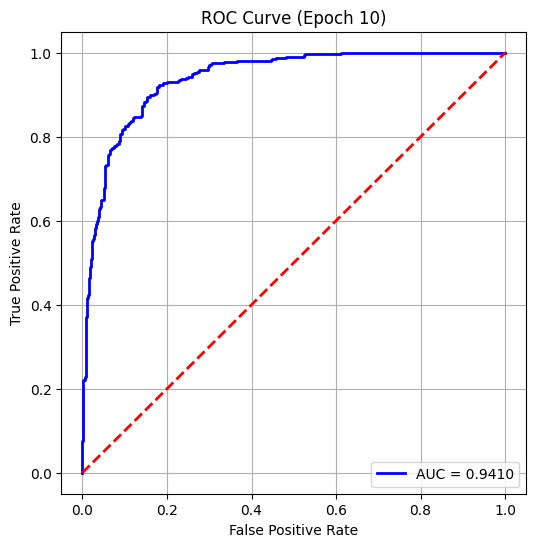

Saved model to siamese_signature_verification.pt  (best AUC=0.9410, dist_thr=0.3207770586013794)


'siamese_signature_verification.pt'

In [44]:
train_siamese(
    data_root="/content/dataset_clean",
    epochs=10,
    batch_size=32,
    lr=1e-3,
    margin=1.0,
    n_pairs=3000,
    size=224,
    emb_dim=128,
    pretrained=True,
    model_save_path="siamese_signature_verification.pt"
)


In [45]:
# Load checkpoint
def load_checkpoint(model_path: str, device: str = device):
  """
  Load a saved SiameseResNet18 checkpoint.
  """
  ckpt = torch.load(model_path, map_location=device, weights_only=False)
  model = SiameseResNet18(embedding_dim=ckpt.get("emb_dim", 128), pretrained=False)
  model.load_state_dict(ckpt["state_dict"])
  model.eval().to(device)
  dist_thr = ckpt.get("dist_threshold", 0.4)
  size = ckpt.get("size", 224)
  return model, float(dist_thr), int(size)


In [46]:
from typing import List, Tuple
from tabulate import tabulate

# Inference helpers
infer_tf_cache = {}
orb_cache = {}


def _get_infer_tf(size: int):
  # small cache to avoid rebuilding transforms
  if size not in infer_tf_cache:
    infer_tf_cache[size] = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3),
    ])
  return infer_tf_cache[size]

def get_orb_descriptors(img_path: str, max_features: int = 500):
  """Compute ORB descriptors with caching."""
  if img_path in orb_cache:
    return orb_cache[img_path]

  img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
  if img is None:
    orb_cache[img_path] = ([], None)
    return [], None

  orb = cv2.ORB_create(nfeatures=max_features)
  kp, des = orb.detectAndCompute(img, None)
  orb_cache[img_path] = (kp, des)
  return kp, des

def orb_match_percentage_cached(img1_path: str, img2_path: str, max_features: int = 500) -> float:
  """Compute ORB keypoint match % using cached descriptors."""
  kp1, des1 = get_orb_descriptors(img1_path, max_features)
  kp2, des2 = get_orb_descriptors(img2_path, max_features)

  if des1 is None or des2 is None or len(kp1) == 0 or len(kp2) == 0:
    return 0.0

  bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
  matches = bf.match(des1, des2)
  match_pct = (len(matches) / min(len(kp1), len(kp2))) * 100
  return round(match_pct, 2)


# Deep learning predictions with SNN
def predict_two_images(img1_path: str, img2_path: str, model: nn.Module, dist_thr: float, size: int = 224):
  """SNN model only: returns (distance, 'Genuine'/'Forged')."""
  t = _get_infer_tf(size)
  im1 = t(preprocess_signature(img1_path, size)).unsqueeze(0).to(device)
  im2 = t(preprocess_signature(img2_path, size)).unsqueeze(0).to(device)
  with torch.no_grad():
    z1, z2 = model(im1, im2)
    dist = F.pairwise_distance(z1, z2).item()
  pred = "Genuine" if dist < dist_thr else "Forged"
  return dist, pred


def predict_hybrid(img1_path: str,
                   img2_path: str,
                   model: nn.Module,
                   dist_thr: float,
                   orb_thr: float = 35.0,
                   size: int = 224,
                   alpha: float = 0.6,
                   beta: float = 0.4):
  """Weighted hybrid decision using SNN + ORB."""
  dist, _ = predict_two_images(img1_path, img2_path, model, dist_thr, size)
  orb_pct = orb_match_percentage_cached(img1_path, img2_path)

  SNN_score = max(0, 1 - dist / dist_thr)
  orb_score = min(1, orb_pct / orb_thr)
  score = alpha * SNN_score + beta * orb_score
  final = "Genuine" if score >= 0.5 else "Forged"

  return {
      "SNN_dist": dist,
      "SNN_thr": dist_thr,
      "orb_pct": orb_pct,
      "orb_thr": orb_thr,
      "SNN_score": round(SNN_score, 3),
      "orb_score": round(orb_score, 3),
      "score": round(score, 3),
      "final": final
  }



# print results in table format
def print_result_table(results):
    headers = ["Image1", "Image2", "SNN_Dist", "ORB%", "Decision"]
    rows = []
    for r in results:
        rows.append([
            r["img1"].split("/")[-1],   # show only filename
            r["img2"].split("/")[-1],
            f"{r['SNN_dist']:.4f}",
            f"{r['orb_pct']:.1f}",
            r["final"]
        ])
    print(tabulate(rows, headers=headers, tablefmt="grid"))

#predict multi pair simultaneously
def hybrid_batch_predict(model: nn.Module,
                         dist_thr: float,
                         pairs: List[Tuple[str,str]],
                         orb_thr: float = 25.0,
                         size: int = 224):
    results = []
    for img1, img2 in pairs:
      out = predict_hybrid(img1, img2, model, dist_thr, orb_thr=orb_thr, size=size)
      results.append({"img1": img1, "img2": img2, **out})

    print_result_table(results)
    return results


In [47]:
#Run example
def run_example(
    model_path="siamese_signature_verification.pt",
    img1_path=None,
    img2_path=None,
    pairs=None,
    device="cpu",
    orb_thr=35.0,
    verbose=False
):
  """
  Runs example inference using deep-only, hybrid, and batch hybrid methods.
  """

  # Load best checkpoint
  model, dist_thr, sz = load_checkpoint(model_path, device=device)
  print(f"✅ Checkpoint loaded, distance threshold: {dist_thr}\n")

  results = {}

  if img1_path and img2_path:
    # predict_two_images
    dist, pred = predict_two_images(img1_path, img2_path, model, dist_thr, size=sz)
    results["deep_only"] = {"img1": img1_path, "img2": img2_path, "dist": dist, "pred": pred}

    # Hybrid inference
    out = predict_hybrid(img1_path, img2_path, model, dist_thr, orb_thr=orb_thr, size=sz)
    results["hybrid"] = {"img1": img1_path, "img2": img2_path, **out}

    print(" Single Image Inference:\n")
    print_result_table([results["hybrid"]])  # reuse same table

    if verbose:
      print("Deep-only:", results["deep_only"])
      print("Hybrid raw:", out)

  if pairs:
    print("\n Batch Inference:\n")
    batch_results = hybrid_batch_predict(model, dist_thr, pairs, orb_thr=orb_thr, size=sz)
    results["batch"] = batch_results
    if verbose:
      print("Batch Hybrid Raw:", batch_results)

  return results


In [48]:
# Single test
single_pair = run_example(
    model_path="siamese_signature_verification.pt",
    img1_path="/content/dataset_clean/test/genuine/original_10_12.png",
    img2_path="/content/dataset_clean/test/forg/forgeries_10_12.png",
    device=device
)

# Batch test
pairs = [
    ("/content/dataset_clean/test/genuine/original_10_12.png",
     "/content/dataset_clean/test/genuine/original_10_12.png"),
    ("/content/dataset_clean/test/forg/forgeries_23_19.png",
     "/content/dataset_clean/test/genuine/original_23_19.png"),
]

multi_pair = run_example(
    model_path="siamese_signature_verification.pt",
    pairs=pairs,
    device=device
)


✅ Checkpoint loaded, distance threshold: 0.3207770586013794

 Single Image Inference:

+--------------------+---------------------+------------+--------+------------+
| Image1             | Image2              |   SNN_Dist |   ORB% | Decision   |
+====================+=====================+============+========+============+
| original_10_12.png | forgeries_10_12.png |     1.1297 |   23.6 | Forged     |
+--------------------+---------------------+------------+--------+------------+
✅ Checkpoint loaded, distance threshold: 0.3207770586013794


 Batch Inference:

+---------------------+--------------------+------------+--------+------------+
| Image1              | Image2             |   SNN_Dist |   ORB% | Decision   |
+=====================+====================+============+========+============+
| original_10_12.png  | original_10_12.png |     0      |  100   | Genuine    |
+---------------------+--------------------+------------+--------+------------+
| forgeries_23_19.png | original

In [49]:


def visualize_signatures(img1_path, img2_path, size=(155,220)):
  from PIL import Image
  import torchvision.transforms as T

  transform = T.Compose([
      T.Grayscale(num_output_channels=1),
      T.Resize(size,antialias=True),# antialias for better quality
      T.ToTensor()
  ])

  img1 = Image.open(img1_path).convert("L")
  img2 = Image.open(img2_path).convert("L")

  t1 = transform(img1).squeeze(0).numpy()
  t2 = transform(img2).squeeze(0).numpy()

  plt.figure(figsize=(8,4))
  plt.subplot(1,2,1)
  plt.imshow(t1, cmap="gray")
  plt.title("Signature 1")
  plt.axis("off")

  plt.subplot(1,2,2)
  plt.imshow(t2, cmap="gray")
  plt.title("Signature 2")
  plt.axis("off")

  plt.show()


In [50]:
def verify_signature(img1_path, img2_path, model, dist_thr, size, method="hybrid", orb_thr=30.0):
  """
  Verify whether two signatures are Genuine or Forged.
  """
  if method == "SNN":
    dist, pred = predict_two_images(img1_path, img2_path, model, dist_thr, size=size)
    return {
        "method": "SNN",
        "distance": float(round(dist, 4)),
        "decision": pred
    }

  elif method == "hybrid":
    result = predict_hybrid(img1_path, img2_path, model, dist_thr, orb_thr=orb_thr, size=size)
    return {
        "method": "hybrid",
        "SNN_dist": float(round(result["SNN_dist"], 4)),
        "orb_pct": float(round(result["orb_pct"], 2)),
        "score": float(round(result["score"], 3)),
        "decision": result["final"]
    }

  else:
    raise ValueError("Invalid method. Choose 'SNN' or 'hybrid'.")


✅ Checkpoint loaded, threshold = 0.3207770586013794


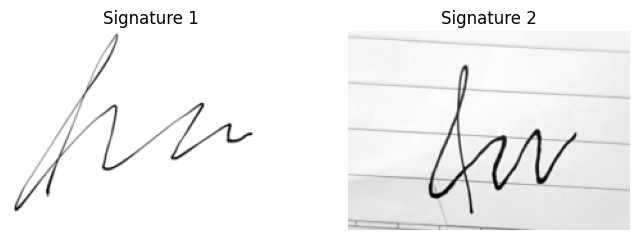

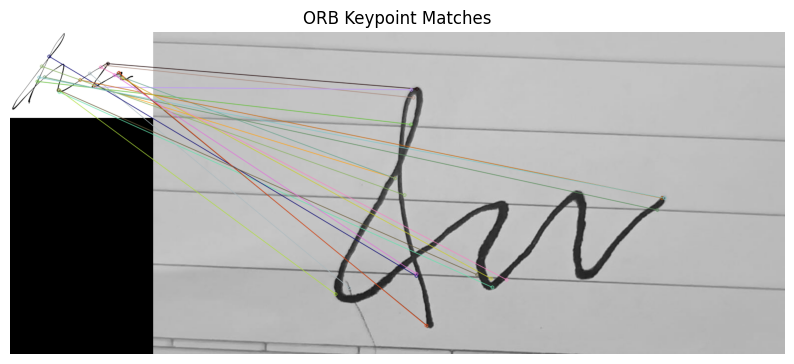

In [62]:
# Load checkpoint first
model, dist_thr, sz = load_checkpoint("siamese_signature_verification.pt", device=device)
print(f"✅ Checkpoint loaded, threshold = {dist_thr}")
visualize_signatures("/content/img1.png", "/content/img2.png", size=(155,220))


visualize_orb_matches("/content/img1.png", "/content/img2.png", max_matches=20)

In [63]:
#Compare signature with SNN
res1 = verify_signature("/content/img1.png", "/content/img2.png", model, dist_thr, sz, method="SNN")
print(res1)


{'method': 'SNN', 'distance': 0.4979, 'decision': 'Forged'}


In [66]:
#Compare Signature with Hybrid(SNN+ORB)
res2 = verify_signature("/content/img1.png", "/content/img2.png",model, dist_thr, sz, method="hybrid")
print(res2)

{'method': 'hybrid', 'SNN_dist': 0.4979, 'orb_pct': 16.58, 'score': 0.221, 'decision': 'Forged'}
